In [12]:
import powersddp as psddp

data = {'load': [100, 15-, 50],
        'discretizations': 3,
        'stages': 3,
        'scenarios': 2,
        'outage_cost': 500,
        'hydro-units': [{'name': 'HU1',
                         'v_max': 100,
                         'v_min': 20,
                         'prod': 0.95,
                         'flow_max': 60,
                         'inflow_scenarios': [[23, 16], [19, 14], [15, 11]]}],
        'thermal-units': [{'name': 'GT1', 'capacity': 15, 'cost': 10},
                          {'name': 'GT2', 'capacity': 10, 'cost': 25}]}

TestSystem = psddp.PowerSystem(data=data)

In [13]:
operation = TestSystem.dispatch()

In [14]:
operation.iloc[0]

,stage,storage_percentage,initial_volume,average_cost
0,3,0%,20.0,55537.50
1,3,50%,60.0,36537.50
2,3,100%,100.0,34400.00
3,2,0%,20.0,60600.00
4,2,50%,60.0,41600.00
5,2,100%,100.0,34448.75
6,1,0%,20.0,64237.50
7,1,50%,60.0,45237.50
8,1,100%,100.0,34763.50


In [8]:
operation.iloc[0].average_cost

6725.0

## Decision Variables

### Hydro Units
- Final volume $v_f$: The final volume of the reservoir after the operational period
- Turbined flow  $v_t$: The ammount of water that was turbined during the period
- Shed volume $v_v$: The ammount of water that was shed in the period
- Initial volume $v_i$
- Influx $afl$

### Thermal Units
- total generation $g_t$: The total amount of generation provided by the unit during the period

### System
- Outage $def$: The total ammount of power that will not be delivered by the system



## The Objective Function

Assuming a problem with 3 generation units (2 TGUs and 1 HGU) let's write down the Objetive Function of our problem:

$$
\begin{equation}
    \begin{aligned}
        \min \quad                    & C_1\cdot g_{t_1} + C_2\cdot g_{t_2} + C_{def}\cdot def + 0.01\cdot v_v\\
        \textrm{s.t.} \quad           & \\
        \textrm{hydro balance} \quad  & v_f(i) = v_i(i) + afl(i) - v_t(i) \\
        \textrm{load supplying} \quad & \rho\cdot v_t + g_{t_1} + g_{t_2} + def = \textrm{load}\\
        \textrm{constraints} \quad    & \\
                                      & v_{f_{min}}\leq v_f \leq v_{f_{max}}\\
                                      & v_{t_{min}}\leq v_t \leq v_{t_{max}}\\
                                      & v_{v_{min}}\leq v_v \leq v_{v_{max}}\\
                                      & g_{t_{min}}\leq g_t^\ast \leq g_{t_{max}}\\
        ^\ast \textrm{for each TGU}& 
    \end{aligned}
\end{equation}
$$

> Later we shall also add the Future Cost Function $\alpha$ in the minimization function 

In [16]:
import cvxopt.modeling as model
from cvxopt import solvers

import pandas as pd
import plotly.graph_objects as go
from plotly.subplots import make_subplots

solvers.options['glpk'] = dict(msg_lev='GLP_MSG_OFF')

def dispatch(system, v_i, inflow, cuts, stage, verbose:bool=False):
    n_tgu = len(system.data['thermal-units'])
    n_hgu = len(system.data['hydro-units'])
    solvers.options['show_progress'] = verbose

    ## Initializing Model Variables
    v_f = model.variable(n_hgu, "Final Volume of the Hydro Unit")
    v_t = model.variable(n_hgu, "Turbined Flow of the Hydro Unit")
    v_v = model.variable(n_hgu, "Shed flow of the Hydro Unit")
    g_t = model.variable(n_tgu, "Power generated by the Thermal Unit")
    deficit = model.variable(1, "Power deficit")
    alpha = model.variable(1, "Future Cost")

    ## Objective Function
    fob = 0
    for i, tgu in enumerate(system.data['thermal-units']):
        fob += tgu["cost"]*g_t[i]
    fob+=TestSystem.data['outage_cost']*deficit[0]
    for i, _ in enumerate(system.data['hydro-units']):
        fob += 0.01*v_v[i]
    fob += 1.0 * alpha[0]

    ## Constraints
    
    ### Hydro Balance
    constraints = []
    for i, hgu in enumerate(system.data['hydro-units']):
        constraints.append( v_f[i] == float(v_i[i]) + float(inflow[i]) - v_t[i] - v_v[i] )

    supplying = 0
    ### Load Supply
    for i, hgu in enumerate(system.data['hydro-units']):
        supplying += hgu["prod"] * v_t[i]

    for i, tgu in enumerate(system.data['thermal-units']):
        supplying += g_t[i]

    supplying += deficit[0]

    constraints.append(supplying == system.data['load'][stage-2])
    

    ### Bounds
    for i, hgu in enumerate(system.data['hydro-units']):
        constraints.append(v_f[i] >= hgu["v_min"])
        constraints.append(v_f[i] <= hgu["v_max"])
        constraints.append(v_t[i] >= 0)
        constraints.append(v_t[i] <= hgu["flow_max"])
        constraints.append(v_v[i] >= 0)

    for i, tgu in enumerate(system.data['thermal-units']):
        constraints.append(g_t[i] >= 0)
        constraints.append(g_t[i] <= tgu["capacity"])

    constraints.append(deficit[0] >= 0)
    constraints.append(alpha[0] >= 0)
    
    ### Cut constraint (Future cost function of forward stage)
    for cut in cuts:
        if cut['stage'] == stage:
            equation = 0
            for hgu in range(n_hgu):
                equation += float(cut['coefs'][hgu])*v_f[hgu]
            equation += float(cut['coef_b'])
            constraints.append(alpha[0] >= equation)
    
    ## Solving
    opt_problem = model.op(objective=fob, constraints=constraints)
    opt_problem.solve(format='dense',solver='glpk')

    ## Print
    if verbose:
        print("Total Cost: {}".format(fob.value()))

        for i, hgu in enumerate(system.data['hydro-units']):
            print("{} {} is {} hm3".format(v_f.name,i,v_f[i].value()))
            print("{} {} is {} hm3".format(v_t.name,i,v_t[i].value()))
            print("{} {} is {} hm3".format(v_v.name,i,v_v[i].value()))

        for i, tgu in enumerate(system.data['thermal-units']):
            print("{} {} is {} MWmed".format(g_t.name,i,g_t[i].value()))

        print("{} is {} MWmed".format(deficit.name,deficit[0].value()))

        for i, hgu in enumerate(system.data['hydro-units']):
            print("The cost of water at Hydro Unit {} is {} hm3".format(i,constraints[i].multiplier.value))

        print("The Marginal Cost is: {}".format(constraints[n_hgu].multiplier.value))
        
    return {
        "deficit": deficit[0].value()[0],
        "operational_marginal_cost": constraints[n_hgu].multiplier.value[0],
        "total_cost": fob.value()[0],
        "future_cost": alpha[0].value()[0],
        "hydro_units": [{
            "v_f": v_f[i].value()[0],
            "v_t": v_t[i].value()[0],
            "v_v": v_v[i].value()[0],
            "water_marginal_cost": constraints[i].multiplier.value[0]} for i in range(n_hgu)],
        "thermal_units": [{"g_t": g_t[i].value()[0]} for i in range(n_tgu)]
    }

def plot_future_cost_function(operation: pd.DataFrame):
    
    n_stages = len(operation['stage'].unique())
    
    fig = make_subplots(rows=n_stages, cols=1)

    i = 1
    for stage in operation['stage'].unique():
        stage_df = operation.loc[operation['stage'] == stage] 
        fig.add_trace(go.Scatter(x=stage_df["v_i"],
                                 y=stage_df['average_cost'],
                                 mode='lines',
                                 name="Stage {}".format(i)), row=stage, col=1)
        i+=1

    fig.update_xaxes(title_text="Final Volume [hm3]")
    fig.update_yaxes(title_text="$/MW")

    fig.update_layout(height=300*TestSystem.data['stages'], title_text="Future Cost Function")
    fig.show()

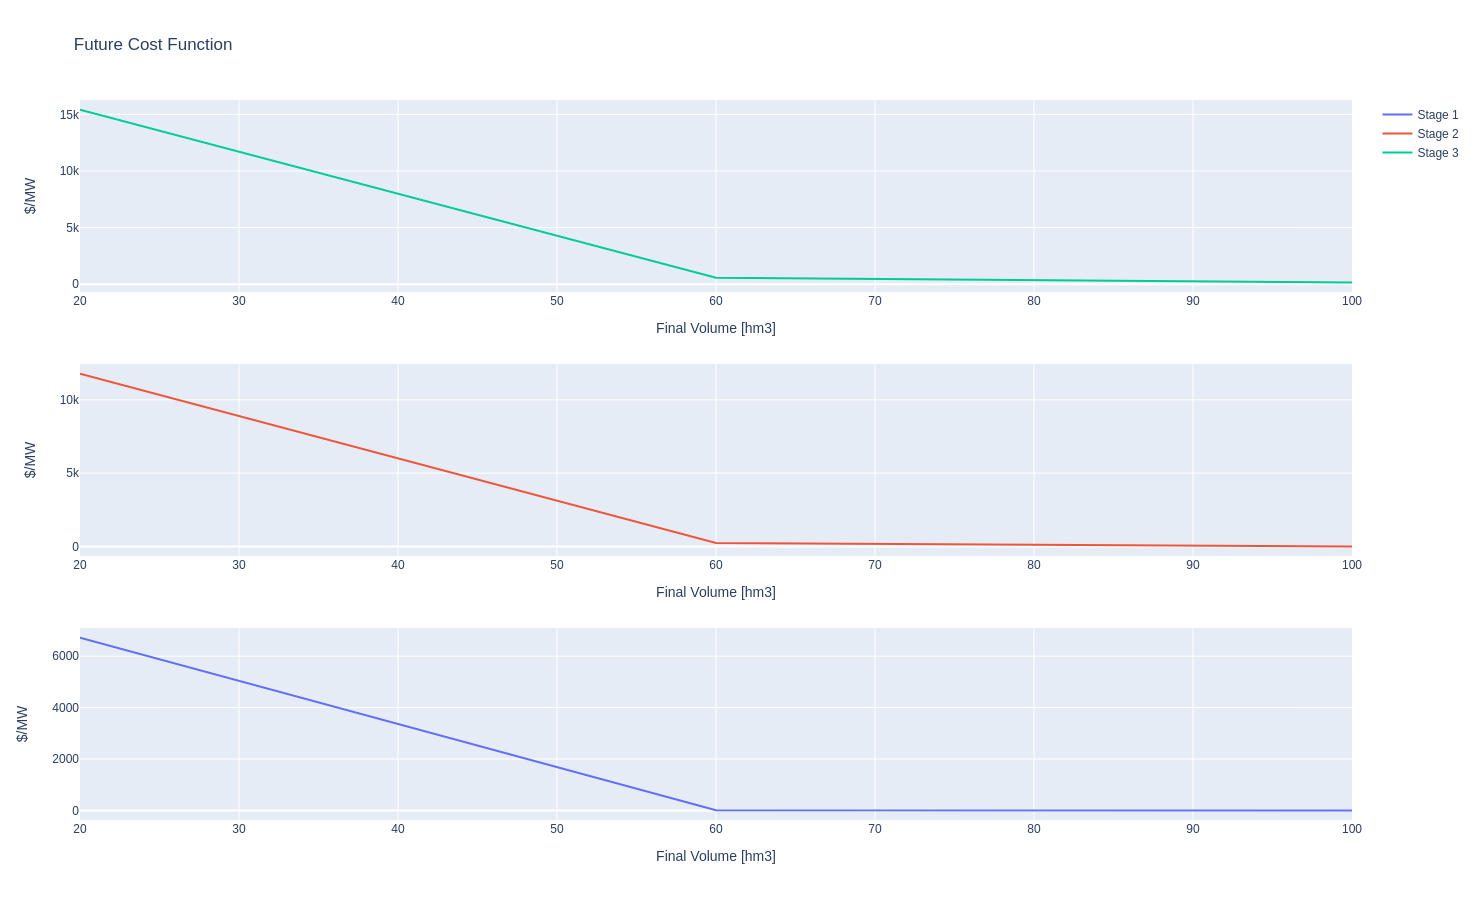

In [17]:
from itertools import product
import numpy as np

n_hgu = len(TestSystem.data['hydro-units'])
n_tgu = len(TestSystem.data['thermal-units'])

step = 100/(TestSystem.data['discretizations']-1)
discretizations = list(product(np.arange(0,100+step,step), repeat=n_hgu))

cuts = []
operation = []
for stage in range(TestSystem.data['stages'],0,-1):
    for discretization in discretizations:
        
        v_i = []
        # For Every Hydro Unit
        for i, hgu in enumerate(TestSystem.data['hydro-units']):
            v_i.append(hgu['v_min'] + (hgu['v_max']-hgu['v_min'])*discretization[i]/100)
        
        # For Every Scenario
        average = 0.
        avg_water_marginal_cost = [0 for _ in TestSystem.data["hydro-units"]]
        for scenario in range(TestSystem.data['scenarios']):
            inflow = []
            for i, hgu in enumerate(TestSystem.data['hydro-units']):
                inflow.append(hgu['inflow_scenarios'][stage-1][scenario])
            
            result = dispatch(TestSystem, v_i, inflow, cuts, stage+1)
            average += result["total_cost"]
            for i, hgu in enumerate(result["hydro_units"]):
                avg_water_marginal_cost[i] += hgu["water_marginal_cost"]

        # Calculating the average of the scenarios
        average = average/TestSystem.data['scenarios']
        coef_b = average
        for i, hgu in enumerate(result["hydro_units"]):
            # ! Invert the coeficient because of the minimization problem inverts the signal
            avg_water_marginal_cost[i] = - avg_water_marginal_cost[i]/TestSystem.data['scenarios']
            coef_b -= v_i[i]*avg_water_marginal_cost[i]
            
        cuts.append({"stage": stage, "coef_b": coef_b, "coefs": avg_water_marginal_cost})
        operation.append({'stage': stage, 'discretization': discretization[i], 'v_i': v_i[0], 'average_cost': round(average,2)})
operation_df = pd.DataFrame(operation)

if n_hgu == 1:
    plot_future_cost_function(operation=operation_df)

In [13]:
operation_df

,stage,discretization,v_i,average_cost
0,3,0.0,20.0,6725.00
1,3,50.0,60.0,7.75
2,3,100.0,100.0,-0.00
3,2,0.0,20.0,11787.50
4,2,50.0,60.0,226.93
5,2,100.0,100.0,0.62
6,1,0.0,20.0,15425.00
7,1,50.0,60.0,576.31
8,1,100.0,100.0,161.68


## Considering the Future Cost Function

### Modelling the cost of water

Now, let's consider the Future Cost Function to back propagate the solutions. By back propagating we assume that the future cost function of the "stage ahead" is used as input for the previous stage solution.

Assuming that any Future Cost Function is aproximated by a series of straigh line discretizations. Any given point can be identified by a straight line, which is mathematically represented by:

$$
\begin{equation}
    \begin{aligned}
        \alpha = a \cdot v_f + b
    \end{aligned}
\end{equation}
$$

Where $\alpha$ is cost at a given point of final volume. Where shall find the coeficients $a$ and $b$ 

- $a$: Is the marginal cost of the water, which comes from the solution of the minimization problem.

If we assume $\alpha = 75$ and $v_f = 60$ which means a cost of $\$60.00$ at Final Volume $60 hm^3$, that gives us:

$$
\begin{equation}
    \begin{aligned}
        b = \alpha - a \cdot v_f
    \end{aligned}
\end{equation}
$$

> Naturaly, this process is repeated for every discretization used in the problem.

> $a$ is given by the average value of every scenario considered when calculating the marginal cost of the water.

If we evaluate for multiple Hydro Units, naturaly:

$$
\begin{equation}
    \begin{aligned}
        \alpha =b + \sum_{i=1}^{n} a_i \cdot v_{i}
    \end{aligned}
\end{equation}
$$

Where $n$ = number of Hydro units

### Considering the cost function in the back propagation

In the previos stage (back propagating from the end to the beggining) we have the objetive function:

$$
\begin{equation}
    \begin{aligned}
        \min \quad                                   & C_1\cdot g_{t_1} + C_2\cdot g_{t_2} + C_{def}\cdot def + 0.01\cdot v_v + \alpha\\
        \textrm{s.t.} \quad                          & \\
        \textrm{hydro balance} \quad                 & v_f(i) = v_i(i) + afl(i) - v_t(i) - v_v(i) \\
        \textrm{load supplying} \quad                & \rho\cdot v_t(i) + g_{t_1} + g_{t_2} + def = \textrm{load}\\
        \textrm{considering the forward state}\quad  & \\
        \textrm{for every scenario} `s` \quad          & \alpha \geq a^{s} \cdot v_f(i) + b^{s}\\
                \textrm{constraints} \quad           & \\
                                                     & v_{f_{min}}\leq v_f(i) \leq v_{f_{max}}\\
                                                     & v_{t_{min}}\leq v_t(i)  \leq v_{t_{max}}\\
                                                     & v_{v_{min}}\leq v_v(i)  \leq v_{v_{max}}\\
                                                     & g_{t_{min}}\leq g_t^\ast \leq g_{t_{max}}\\
        ^\ast \textrm{for each TGU}& 
    \end{aligned}
\end{equation}
$$